In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset,random_split
import matplotlib.pyplot as plt

In [124]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
            num_encoder_layers
        )
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.input_linear(src)
        src = self.transformer_encoder(src)
        output = self.output_linear(src)
        return output

In [125]:
# Load data
X = np.load('/kaggle/input/mydata/X_train_padding.npy')
Y = np.load('/kaggle/input/mydata/y_train_padding.npy')

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [126]:
# Initialize the model, loss function, and optimizer
model = TransformerModel(input_dim=12, output_dim=14)
if torch.cuda.is_available():
    model = model.to('cuda')
criterion = nn.MSELoss()  # Assuming a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [127]:
# Create a TensorDataset
dataset = TensorDataset(X_tensor, Y_tensor)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [130]:
num_epochs = 10
train_losses = []
test_losses = []

Epoch [1/10], Avg. Train Loss: 1411.8715, Avg. Test Loss: 1418.1790
Epoch [2/10], Avg. Train Loss: 1284.1944, Avg. Test Loss: 1272.4430
Epoch [3/10], Avg. Train Loss: 1145.8451, Avg. Test Loss: 1136.6037
Epoch [4/10], Avg. Train Loss: 1024.3775, Avg. Test Loss: 1016.2877
Epoch [5/10], Avg. Train Loss: 922.8711, Avg. Test Loss: 917.6236
Epoch [6/10], Avg. Train Loss: 847.2544, Avg. Test Loss: 841.1196
Epoch [7/10], Avg. Train Loss: 798.1073, Avg. Test Loss: 782.2252
Epoch [8/10], Avg. Train Loss: 755.2850, Avg. Test Loss: 740.1938
Epoch [9/10], Avg. Train Loss: 723.8257, Avg. Test Loss: 711.3024
Epoch [10/10], Avg. Train Loss: 706.6112, Avg. Test Loss: 692.1287


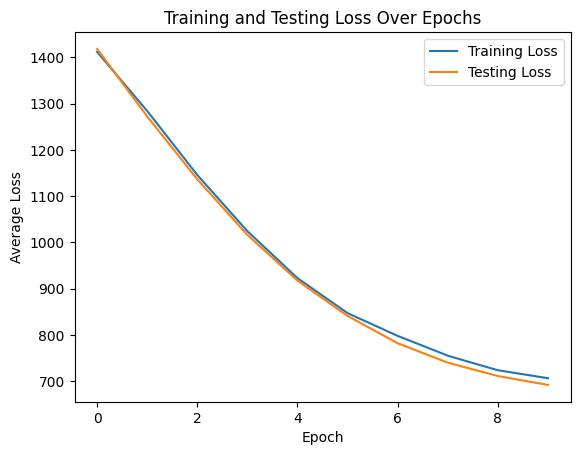

In [131]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    
    for batch_data, batch_target in train_loader:
        if torch.cuda.is_available():
            batch_data, batch_target = batch_data.to('cuda'), batch_target.to('cuda')
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_epoch_train_loss)
    
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_target in test_loader:
            if torch.cuda.is_available():
                batch_data, batch_target = batch_data.to('cuda'), batch_target.to('cuda')
            outputs = model(batch_data)
            loss = criterion(outputs, batch_target)
            
            epoch_test_loss += loss.item()
    
    avg_epoch_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_epoch_test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Train Loss: {avg_epoch_train_loss:.4f}, Avg. Test Loss: {avg_epoch_test_loss:.4f}')

# Plot the training and testing loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig('Trans_training_testing_loss.png')
plt.show()